In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import pickle

from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import *
from keras.applications.resnet50 import ResNet50, preprocess_input

Using TensorFlow backend.


In [2]:
# import flickr 8K dataset

with open("flickr8k/flickr8k_text/Flickr8k.token.txt") as f:
    cap_data = f.read()

img_captions = {}
cap_data = cap_data.split('\n')
for line in cap_data:
    arr = line.split('\t')
    
    name = arr[0].split('.')[0]
    cap = arr[-1]
    
    if img_captions.get(name) is None:
        img_captions[name] = []
    
    img_captions[name].append(cap)

In [3]:
print(img_captions['2000459828_3c9e109106'])

['A group of people stand in front of a rock formation .', "Little kid on a man 's shoulders and another man holding a blue backpack in front of a canyon .", 'The men are walking away from the rocks with a child .', 'There are two men and a kid hiking outside .', 'Two men are hiking with a small child near to some interesting shape rock formations .']


In [4]:
# Clean all captions

def clean_text(text):
    text = re.sub("[^a-z]+", ' ', text.lower())
    
    words = text.split()
    words = [w for w in words if len(w) > 1]
    
    text = ' '.join(words)
    return text

for desc_list in img_captions.values():
    for ix in range(len(desc_list)):
        desc_list[ix] = clean_text(desc_list[ix])

In [5]:
print(img_captions['2000459828_3c9e109106'])

['group of people stand in front of rock formation', 'little kid on man shoulders and another man holding blue backpack in front of canyon', 'the men are walking away from the rocks with child', 'there are two men and kid hiking outside', 'two men are hiking with small child near to some interesting shape rock formations']


In [6]:
# Compute total and unique no. of words in all captions

all_vocab = []
uniq_vocab = set()

for desc_list in img_captions.values():
    for desc in desc_list:
        words = desc.split()
        uniq_vocab.update(words)
        
        for w in words:
            all_vocab.append(w)
            
print('unique words:', len(uniq_vocab))
print('total words:', len(all_vocab))

counter = Counter(all_vocab)
count_dic = dict(counter)

# Discard all words having count less than threshold

threshold_val = 10
sort_count = sorted(count_dic.items(), key=lambda x: x[1], reverse=True)

new_vocab = [x[0] for x in sort_count if x[1] > threshold_val]
print('modified vocab:', len(new_vocab))

unique words: 8424
total words: 373837
modified vocab: 1845


In [7]:
# Load training and testing data image names

with open('flickr8k/flickr8k_text/Flickr_8k.trainImages.txt') as f:
    train_f = f.read()
    
with open('flickr8k/flickr8k_text/Flickr_8k.testImages.txt') as f:
    test_f = f.read()

train_imgs = [img[:-4] for img in train_f.split()]
test_imgs = [img[:-4] for img in test_f.split()]

print(len(train_imgs))
print(len(test_imgs))

6000
1000


In [8]:
# Classify all img captions into train and test

train_captions = {}
test_captions = {}

for t in train_imgs:
    train_captions[t] = []
    for cap in img_captions[t]:
        train_captions[t].append("startseq " + cap + " endseq")
        
for t in test_imgs:
    test_captions[t] = []
    for cap in img_captions[t]:
        test_captions[t].append("startseq " + cap + " endseq")

In [9]:
print(train_captions['3000428313_8a1e65e20e'])

['startseq boy in blue wetsuit is riding surfboard endseq', 'startseq boy rides surfboard over small wave in bright blue water endseq', 'startseq boy wearing blue wetsuit rides on blue surfboard endseq', 'startseq the boy is riding blue board in the water endseq', 'startseq two kids in blue wetsuits surf endseq']


In [10]:
# Data Preprocessing - images
model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))

model_new = Model(inputs=model.input, outputs=model.layers[-2].output)
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [11]:
# Encodes image into feature vector (1x2048)
def encode_img(img):
    
    # Preprocess image
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    
    f_vec = model_new.predict(img)
    f_vec = f_vec.reshape((-1, ))
    
    return f_vec

In [13]:
# Encoding all train and test images

images = "flickr8k/images/"
encoded_train = {}
encoded_test = {}

for ix, img in enumerate(train_imgs):
    path = images + train_imgs[ix] + ".jpg"
    enc_img = encode_img(path)
    encoded_train[train_imgs[ix]] = enc_img
    if ix%100 == 0:
        print(ix, 'train images encoded')
    

for ix, img in enumerate(test_imgs):
    path = images + test_imgs[ix] + ".jpg"
    enc_img = encode_img(path)
    encoded_test[test_imgs[ix]] = enc_img
    if ix%100 == 0:
        print(ix, 'train images encoded')

0 train images encoded
100 train images encoded
200 train images encoded
300 train images encoded
400 train images encoded
500 train images encoded
600 train images encoded
700 train images encoded
800 train images encoded
900 train images encoded
1000 train images encoded
1100 train images encoded
1200 train images encoded
1300 train images encoded
1400 train images encoded
1500 train images encoded
1600 train images encoded
1700 train images encoded
1800 train images encoded
1900 train images encoded
2000 train images encoded
2100 train images encoded
2200 train images encoded
2300 train images encoded
2400 train images encoded
2500 train images encoded
2600 train images encoded
2700 train images encoded
2800 train images encoded
2900 train images encoded
3000 train images encoded
3100 train images encoded
3200 train images encoded
3300 train images encoded
3400 train images encoded
3500 train images encoded
3600 train images encoded
3700 train images encoded
3800 train images encode

In [16]:
# Saving Encoded features to disk

with open("./encoded_train_imgs.pkl", "wb") as f:
    pickle.dump(encoded_train, f)
with open("./encoded_test_imgs.pkl", "wb") as f:
    pickle.dump(encoded_test, f)

In [18]:
# Loading Encoded features from disk

with open("./encoded_train_imgs.pkl", "rb") as f:
    encoded_train = pickle.load(f)
with open("./encoded_test_imgs.pkl", "rb") as f:
    encoded_test = pickle.load(f)

In [19]:
# Data preprocessing - captions

word_to_idx = {}
idx_to_word = {}

ix = 1
for w in new_vocab:
    word_to_idx[w] = ix
    idx_to_word[ix] = w
    ix += 1

word_to_idx['startseq'] = ix
word_to_idx['endseq'] = ix+1

idx_to_word[ix] = 'startseq'
idx_to_word[ix+1] = 'endseq'

vocab_size = ix+2
print('vocab size:', vocab_size)

vocab size: 1848


In [20]:
maxLen = 1
for key in train_captions.keys():
    for cap in train_captions[key]:
        maxLen = max(maxLen, len(cap.split()))

print('max Length of review', maxLen)

max Length of review 35


In [21]:
# Generator function

def data_generator(train_captions, encoded_train, word_to_idx, maxLen, imgs_per_batch):
    X1, X2, Y = [], [], []
    n = 0
    
    while True:    
        for key, desc_list in train_captions.items():
            n += 1
            img_vec = encoded_train[key]
            
            for cap in desc_list:
                seq = [word_to_idx[w] for w in cap.split() if w in word_to_idx]
                
                for i in range(1, len(seq)):
                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxLen, value=0, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(img_vec)
                    X2.append(in_seq)
                    Y.append(out_seq)
                    
            if n == imgs_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(Y)]
                X1, X2, Y = [], [], []
                n = 0

In [ ]:
# for i in data_generator(train_captions, encoded_train, word_to_idx, maxLen, 3):
#     X, y = i
#     print(X[0].shape, X[1].shape, y.shape)
#     break

In [22]:
# Word Embeddings

word_2_vec = {}
with open('glove.6B.50d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        arr = line.split()
        word = arr[0]
        vec = np.array(arr[1:], dtype='float32')
        
        word_2_vec[word] = vec

In [24]:
# Get Output Embeddings

emb_dim = 50
emb_matrix_out = np.zeros((vocab_size, emb_dim))

for w, ix in word_to_idx.items():
    emb_vec = word_2_vec.get(w)
    if emb_vec is not None:
        emb_matrix_out[ix] = emb_vec

In [26]:
# Model Architecture

# image feature extractor model
input_img_fea = Input(shape=(2048, ))
layer_i1 = Dropout(0.3)(input_img_fea)
layer_i2 = Dense(256, activation='relu')(layer_i1)

# partial caption sequence model
input_cap = Input(shape=(maxLen, ))
layer_c1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
layer_c2 = Dropout(0.3)(layer_c1)
layer_c3 = LSTM(256)(layer_c2)

# Combined layers
decoder1 = add([layer_i2, layer_c3])
decoder2 = Dense(256, activation='relu')(decoder1)
decoder3 = Dense(vocab_size, activation='softmax')(decoder2)

# Combined model
model = Model(inputs=[input_img_fea, input_cap], outputs=[decoder3])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 35, 50)       92400       input_5[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 2048)         0           input_4[0][0]                    
____________________________________________________________________________________________

In [27]:
model.layers[2].set_weights([emb_matrix_out])
model.layers[2].trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy')

In [28]:
# Train model
epochs = 20
imgs_per_batch=3
steps = len(train_captions) // imgs_per_batch

for i in range(epochs):
    generator = data_generator(train_captions, encoded_train, word_to_idx, maxLen, imgs_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps)
    model.save('best_model.h5')

Epoch 1/1
2000/2000 [==============================] - 583s 292ms/step - loss: 4.2882
Epoch 1/1
2000/2000 [==============================] - 581s 290ms/step - loss: 3.5747
Epoch 1/1
2000/2000 [==============================] - 576s 288ms/step - loss: 3.3210
Epoch 1/1
2000/2000 [==============================] - 570s 285ms/step - loss: 3.1652
Epoch 1/1
2000/2000 [==============================] - 580s 290ms/step - loss: 3.0528
Epoch 1/1
2000/2000 [==============================] - 619s 309ms/step - loss: 2.9644
Epoch 1/1
2000/2000 [==============================] - 694s 347ms/step - loss: 2.8931
Epoch 1/1
2000/2000 [==============================] - 616s 308ms/step - loss: 2.8392
Epoch 1/1
2000/2000 [==============================] - 675s 338ms/step - loss: 2.7918
Epoch 1/1
2000/2000 [==============================] - 719s 359ms/step - loss: 2.7497
Epoch 1/1
2000/2000 [==============================] - 725s 362ms/step - loss: 2.7184
Epoch 1/1
2000/2000 [==============================] -

In [42]:
# Make predictions

def predict(enc_img):
    in_seq = "startseq"
    
    for i in range(maxLen):
        seq = [word_to_idx[w] for w in in_seq.split() if w in word_to_idx]
        seq = pad_sequences([seq], maxLen, padding='post')
        
        y_pred = model.predict([enc_img, seq])
        y_pred = np.argmax(y_pred)
        
        w_pred = idx_to_word[y_pred]
        in_seq += " " + w_pred
        if w_pred == 'endseq':
            break
    
    return in_seq[9: -7]

In [43]:
# Choose random image from test set
def show_results(n = 10):
    res = np.random.randint(0, 1000, n)
    img_ids = list(encoded_test.keys())
    
    for ix in res:
        img_id = img_ids[ix]
        
        enc_img = encoded_test[img_id].reshape((1, -1))
        cap = predict(enc_img)
        print('Caption:', cap)

        img = plt.imread(images + img_id + ".jpg")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

Caption: girl in bikini bikini is standing on rocks near the ocean


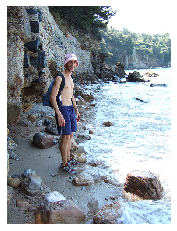

Caption: boy swings on tree lines


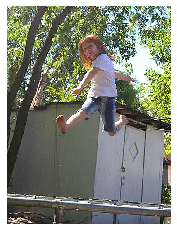

Caption: the man in the red shirt is sitting on the red motorcycle


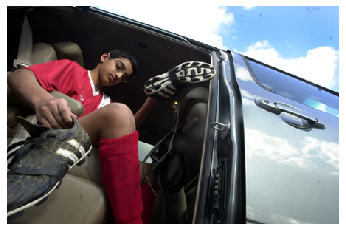

Caption: crowd of people are standing around stadium of dimly


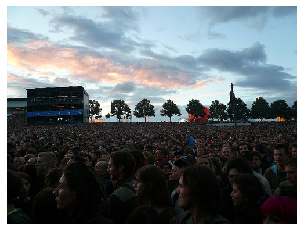

Caption: man on motorcycle


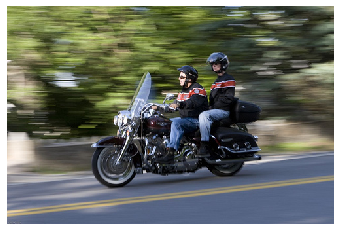

In [51]:
show_results(5)